### script for classifying convective type of rainfall
### using GridRad data for each Bukovsky region
### date created: 1 Sept. 2021
### author: doughert@ucar.edu

In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from netCDF4 import Dataset, num2date
from datetime import datetime, date, timedelta
import glob
import xarray as xr
#from wrf import getvar, ALL_TIMES

### path to GridRada data (available 1995–2017)

In [2]:
rdata_path = '/gpfs/fs1/collections/rda/data/ds841.0/'

In [3]:
### open test files
test = xr.open_dataset(rdata_path+'201005/nexrad_3d_v3_1_20100502T220000Z.nc')
radar_lat = test['Latitude']
radar_lon = test['Longitude']
radar_Z = test['Altitude']

x = len(radar_lon.values)
y = len(radar_lat.values)
z = len(radar_Z.values)

### get list of 3 hourly dates/times between 1995-2017

In [4]:
start_date = pd.Timestamp('1995-01-01T00')
end_date = pd.Timestamp('2017-12-31T23')

In [5]:
print(start_date)
print(end_date)

1995-01-01 00:00:00
2017-12-31 23:00:00


In [6]:
def perdelta(start, end, delta):
    curr = start
    while curr <= end:
        yield curr
        curr += delta
        
date_list =[]

for result in perdelta(start_date, end_date, timedelta(hours=3)):
    date_list.append(result.strftime('%Y%m%d'+'T'+'%H%M%S'))

### GridRad filter routine

In [7]:
def filter(data0):

    # Import python libraries
    import sys
    import os
    import numpy as np

    #Extract year from GridRad analysis time string
    year = data0.Analysis_time[0:4]

    wmin        = 0.1                     # Set absolute minimum weight threshold for an observation (dimensionless)
    wthresh     = 1.33 - 1.0*(int(year) < 2009)# Set default bin weight threshold for filtering by year (dimensionless)
    freq_thresh = 0.6                     # Set echo frequency threshold (dimensionless)
    Z_H_thresh  = 18.5                    # Reflectivity threshold (dBZ)
    nobs_thresh = 2                       # Number of observations threshold

    # Extract dimension sizes
    nx = len(radar_lon.values)
    ny = len(radar_lat.values)
    nz = len(radar_Z.values)

    echo_frequency = np.zeros((nz,ny,nx))# Create array to compute frequency of radar obs in grid volume with echo

    ipos = np.where(data0['Nradobs'] > 0)# Find bins with obs 
    npos = len(ipos[0])# Count number of bins with obs
    
    # Compute echo frequency (number of scans with echo out of total number of scans)
    if (npos > 0):
        echo_frequency[ipos] = (data0['Nradecho'].values)[ipos]/(data0['Nradobs'].values)[ipos]

    inan = np.where(np.isnan((refl_val_3d))) # Find bins with NaNs 
    nnan = len(inan[0]) # Count number of bins with NaNs

    if (nnan > 0): ((data0['Reflectivity'][refl_val_3d]))[inan] = 0.0

    # Find observations with low weight
    ifilter = np.where( (wrefl_val_3d < wmin )   | \
                        ((wrefl_val_3d < wthresh ) & (refl_val_3d <= Z_H_thresh)) |
                        ((echo_frequency  < freq_thresh) &  (data0['Nradobs'] > nobs_thresh)))

    nfilter = len(ifilter[0])# Count number of bins that need to be removed

    # Remove low confidence observations
    if (nfilter > 0): (refl_val_3d)[ifilter] = float('nan')

    # Replace NaNs that were previously removed
    if (nnan > 0): (refl_val_3d)[inan] = float('nan')

    # Return filtered data0
    return data0

In [8]:
def remove_clutter(data0, **kwargs):

    # Set defaults for optional parameters
    if ('skip_weak_ll_echo' not in kwargs): skip_weak_ll_echo = 0

    # Import python libraries
    import sys
    import os
    import numpy as np

    # Set fractional areal coverage threshold for speckle identification
    areal_coverage_thresh = 0.32

    # Extract dimension sizes
    nx = len(radar_lon.values)
    ny = len(radar_lat.values)
    nz = len(radar_Z.values)

    # Copy altitude array to 3 dimensions
    zzz = (((data0['Altitude'].values).reshape(nz,1,1)).repeat(ny, axis = 1)).repeat(nx, axis = 2)

    # First pass at removing speckles
    fin = np.isfinite(refl_val_3d)

    # Compute fraction of neighboring points with echo
    cover = np.zeros((nz,ny,nx))
    for i in range(-2,3):
        for j in range(-2,3):
            cover += np.roll(np.roll(fin, i, axis=2), j, axis=1)
    cover = cover/25.0

    # Find bins with low nearby areal echo coverage (i.e., speckles) and remove (set to NaN).
    ibad = np.where(cover <= areal_coverage_thresh)
    nbad = len(ibad[0])
    if (nbad > 0): (refl_val_3d)[ibad] = float('nan')

    # Attempts to mitigate ground clutter and biological scatterers
    if (skip_weak_ll_echo == 0):
        # First check for weak, low-level echo
        inan = np.where(np.isnan(refl_val_3d))# Find bins with NaNs 
        nnan = len(inan[0])# Count number of bins with NaNs

        if (nnan > 0): (refl_val_3d)[inan] = 0.0

        # Find weak low-level echo and remove (set to NaN)
        ibad = np.where((refl_val_3d < 10.0) & (zzz <= 4.0))
        nbad = len(ibad[0])
        if (nbad > 0): (refl_val_3d)[ibad] = float('nan')

        # Replace NaNs that were removed
        if (nnan > 0): (refl_val_3d)[inan] = float('nan')

        # Second check for weak, low-level echo
        inan = np.where(np.isnan(refl_val_3d))# Find bins with NaNs 
        nnan = len(inan[0])# Count number of bins with NaNs

        if (nnan > 0): (refl_val_3d)[inan] = 0.0

        refl_max   = np.nanmax(refl_val_3d,             axis=0)
        echo0_max  = np.nanmax((refl_val_3d >  0.0)*zzz, axis=0)
        echo0_min  = np.nanmin((refl_val_3d >  0.0)*zzz, axis=0)
        echo5_max  = np.nanmax((refl_val_3d >  5.0)*zzz, axis=0)
        echo15_max = np.nanmax((refl_val_3d> 15.0)*zzz, axis=0)

        # Replace NaNs that were removed
        if (nnan > 0): (refl_val_3d)[inan] = float('nan')

        # Find weak and/or shallow echo
        ibad = np.where(((refl_max   <  20.0) & (echo0_max  <= 4.0) & (echo0_min  <= 3.0)) | \
                         ((refl_max   <  10.0) & (echo0_max  <= 5.0) & (echo0_min  <= 3.0)) | \
                         ((echo5_max  <=  5.0) & (echo5_max  >  0.0) & (echo15_max <= 3.0)) | \
                         ((echo15_max <   2.0) & (echo15_max >  0.0)))
        nbad = len(ibad[0])
        if (nbad > 0):
            kbad = (np.zeros((nbad))).astype(int)
            for k in range(0,nz):
                (refl_val_3d)[(k+kbad),ibad[0],ibad[1]] = float('nan')


    # Find clutter below convective anvils
    k4km = (np.where(data0['Altitude'].values >= 4.0)[0])[0]
    fin  = np.isfinite(refl_val_3d)
    ibad = np.where((fin[k4km,:,:]          == 0) & \
                    (np.sum(fin[k4km:(nz  -1),:,:], axis=0) >  0) & \
                    (np.sum(fin[   0:(k4km-1),:,:], axis=0) >  0))
    nbad = len(ibad[0])
    if (nbad > 0):
        kbad = (np.zeros((nbad))).astype(int)
        for k in range(0,k4km+1):
            (refl_val_3d)[(k+kbad),ibad[0],ibad[1]] = float('nan')

    # Second pass at removing speckles
    fin = np.isfinite(refl_val_3d)

    # Compute fraction of neighboring points with echo
    cover = np.zeros((nz,ny,nx))
    for i in range(-2,3):
        for j in range(-2,3):
            cover += np.roll(np.roll(fin, i, axis=2), j, axis=1)
    cover = cover/25.0

    # Find bins with low nearby areal echo coverage (i.e., speckles) and remove (set to NaN).
    ibad = np.where(cover <= areal_coverage_thresh)
    nbad = len(ibad[0])
    if (nbad > 0): (refl_val_3d)[ibad] = float('nan')

    return data0

### import 3 hourly radar data

In [10]:
print('radar data importing-this could take awhile')

radar data importing-this could take awhile


#### remove problematic file from date list

In [11]:
del date_list[8219]
#del date_list[28806]

In [12]:
#del date_list[42723]

#### rerun script for each 2-year period 

In [59]:
print(date_list[5847])  #1995-1996
print(date_list[14606]) #1997-1999
print(date_list[23375]) #2000-2002
print(date_list[32143]) #2003-2005
print(date_list[40911]) #2006-2008
print(date_list[49671]) #2009-2011
print(date_list[58439]) #2012-2014
print(date_list[67206]) #2015-2017

19961231T210000
19991231T210000
20030101T000000
20060101T000000
20090101T000000
20120101T000000
20150101T000000
20171231T210000


In [19]:
### %%time
import os.path

conus_refl = []
missing_times = []

### Find radar files that match 3 h flood dates
#for c, item in enumerate(date_list[28804:28809]): 
for c, item in enumerate(date_list[32100:32150]): 
    c = c + 32100
    print(c)
    print(item)
    for name in glob.glob(os.path.join(rdata_path+'**/nexrad_3d_v3_1_*')):
        if item in name:
            print(name)
            # open file if it matches flood date
            file_match = xr.open_dataset(name, engine='h5netcdf')
            if len(file_match.files_merged)>1: 
            # get variables from file 
                refl_val = np.zeros(x*y*z)
                wrefl_val = np.zeros(x*y*z)
                refl_val[file_match.index] = file_match['Reflectivity']
                wrefl_val[file_match.index] = file_match['wReflectivity']

                # reshape into 3D coords (24, 2301,1201)
                refl_val_3d = refl_val.reshape(z,y,x)
                wrefl_val_3d = wrefl_val.reshape(z,y,x)

                # apply filer
                radar_filter = filter(file_match)

                # de-clutter data
                #radar_declut = remove_clutter(radar_filter)
                refl_val_clean = np.zeros(x*y*z)
                refl_val_clean[radar_filter.index] = radar_filter['Reflectivity']
                refl_val_clean_3d = refl_val_clean.reshape(z,y,x)

                # get max reflectivity
                max_refl = np.nanmax(refl_val_clean_3d, axis=0)

                da = xr.DataArray(data=max_refl, dims=["y", "x", ], coords=dict(
                                                 lon=(["x"], radar_lon.values),
                                                 lat=(["y"], radar_lat.values),
                                                 ),
                                                 attrs=dict(
                                                 description="Max reflectivity",
                                                 units="dBZ", 
                                                  )).rename("refl%d"%c)
                # add time to df 
                ds = da.expand_dims(time=date_list[c:c+1])

                file_match.close()
                # append values to list
                conus_refl.append(ds)   
            else:
                missing_times.append(date_list[c:c+1])

32100
20051226T150000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051226T150000Z.nc
32101
20051226T180000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051226T180000Z.nc
32102
20051226T210000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051226T210000Z.nc
32103
20051227T000000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051227T000000Z.nc
32104
20051227T030000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051227T030000Z.nc
32105
20051227T060000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051227T060000Z.nc
32106
20051227T090000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051227T090000Z.nc
32107
20051227T120000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051227T120000Z.nc
32108
20051227T150000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexrad_3d_v3_1_20051227T150000Z.nc
32109
20051227T180000
/gpfs/fs1/collections/rda/data/ds841.0/200512/nexra

### delete large items

In [53]:
import sys
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') \
        and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('NamespaceMagics', 896),
 ('Dataset', 408),
 ('date', 408),
 ('timedelta', 408),
 ('conus_refl', 184),
 ('filter', 136),
 ('perdelta', 136),
 ('refl_val_3d', 136),
 ('refl_val_clean_3d', 136),
 ('remove_clutter', 136),
 ('wrefl_val_3d', 136),
 ('name', 129),
 ('end_date', 112),
 ('file_match', 112),
 ('radar_filter', 112),
 ('result', 112),
 ('start_date', 112),
 ('idx', 104),
 ('big_xr', 96),
 ('da', 96),
 ('ds', 96),
 ('radar_Z', 96),
 ('radar_lat', 96),
 ('radar_lon', 96),
 ('rdata_path', 88),
 ('ccrs', 72),
 ('cfeature', 72),
 ('nc', 72),
 ('np', 72),
 ('num2date', 72),
 ('pd', 72),
 ('plt', 72),
 ('xr', 72),
 ('item', 64),
 ('i', 32),
 ('c', 28),
 ('x', 28),
 ('y', 28),
 ('z', 28)]

In [17]:
del refl_val
del refl_val_clean
del wrefl_val
del max_refl
del date_list

### make a map

In [22]:
from cartopy.io import shapereader
import geopandas as gp
from geopandas import GeoDataFrame

us_st = gp.GeoDataFrame.from_file(
    "/glade/work/doughert/flooddata/cb_2013_us_state_5m_2/cb_2013_us_state_5m.shp")
us_st.head()
print(len(us_st))
state = us_st['geometry'].values[0:56]

56


In [24]:
print(conus_refl[0])

<xarray.DataArray 'refl32100' (time: 1, y: 1201, x: 2301)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time     (time) <U15 '20051226T150000'
    lon      (x) float32 245.0 245.0 245.0 245.1 ... 290.9 291.0 291.0 291.0
    lat      (y) float32 25.0 25.02 25.04 25.06 25.08 ... 48.94 48.96 48.98 49.0
Dimensions without coordinates: y, x
Attributes:
    description:  Max reflectivity
    units:        dBZ


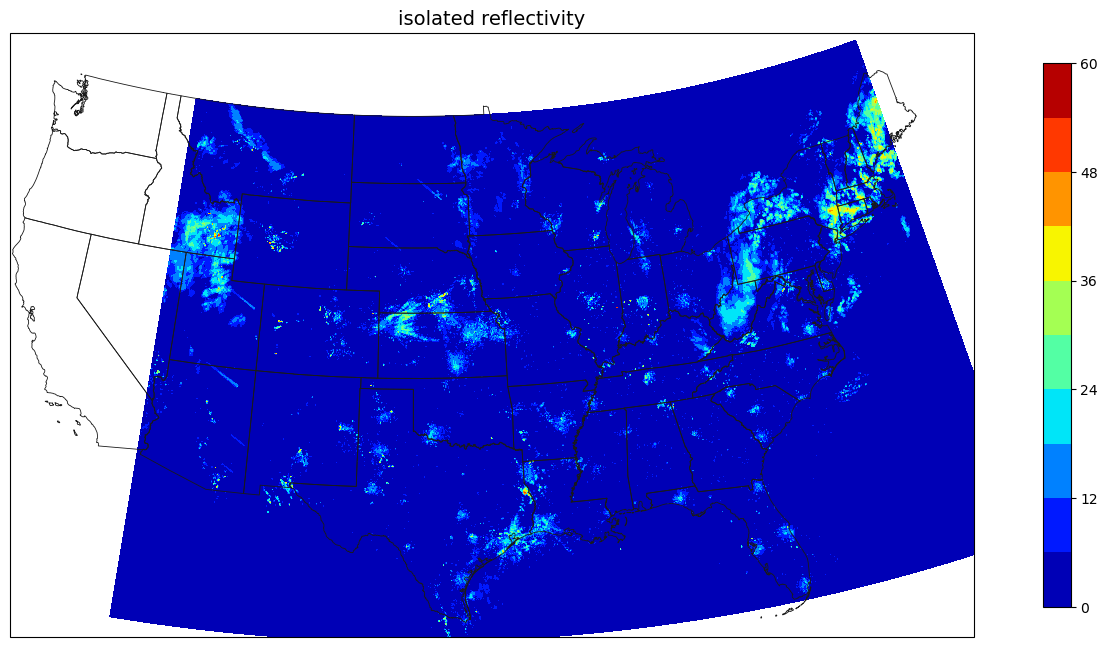

In [28]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as colors

fig = plt.figure(figsize = (18,8), dpi = 100)

## original polygons
ax2 = plt.subplot(1, 1, 1,  projection=ccrs.LambertConformal(central_longitude=-100))
ax2.add_geometries(state, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.1', linewidth = 0.6)
ax2.set_extent([-120, -72, 25, 50], crs=ccrs.PlateCarree())
v = np.linspace(0, 60, 11,endpoint = True)
c1 = ax2.contourf(conus_refl[0].lon.values-360, conus_refl[0].lat.values, conus_refl[0][0].values,v,
                    cmap='jet', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(c1, orientation = 'vertical', ax=ax2, shrink=0.9)
ax2.set_title('isolated reflectivity', fontsize=14)


#plt.savefig('CONUS_frontid_850thetae_00Z_01Jan_1995.png', bbox_inches='tight', dpi=250)
plt.show()


### merge reflectivities into one dataset

In [38]:
conus_refl_df = xr.concat(conus_refl, dim='time')

In [39]:
print(conus_refl_df)

<xarray.DataArray 'refl28804' (time: 3, y: 1201, x: 2301)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time     (time) <U15 '20041109T120000' '20041109T150000' '20041109T180000'
    lon      (x) float32 245.0 245.0 245.0 245.1 ... 290.9 291.0 291.0 291.0
    lat      (y) float32 

In [70]:
print('exporting dataset')

exporting dataset


In [56]:
conus_refl_df.to_netcdf('test_sub.nc')

In [43]:
with open("miss_times_2003_2005.txt", "w") as output:
    output.write(str(missing_times))

In [71]:
print('data exported')

data exported
